In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import logging
import pickle

import numpy as np

import py21cmfast as p21c

sys.path.append("..")
from dm21cm.dm_params import DMParams
from dm21cm.evolve import evolve
import dm21cm.physics as phys
from dm21cm.utils import load_dict

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colormaps as cms
mpl.rc_file("../matplotlibrc")

/n/home07/yitians/.conda/envs/21cmfast/lib/python3.10/site-packages/py21cmfast/_cfg.py:58: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn(
/n/home07/yitians/.conda/envs/21cmfast/lib/python3.10/site-packages/py21cmfast/_cfg.py:42: UserWarning: Your configuration file is out of date. Updating...
  warnings.warn("Your configuration file is out of date. Updating...")
INFO:root:Using 21cmFAST version 0.1.dev1579+g6b1da6d.d20230702


## config

In [2]:
print(os.cpu_count())

48


In [3]:
# check cached runs
l = os.listdir(os.environ['P21C_CACHE_DIR'])
l.sort()
[print(i) for i in l];

phph_dhinit_s8zero
phph_dhinit_s8zero_fine
phph_dhinit_s8zero_fine_DEBUG


In [11]:
! ls -l /n/home07/yitians/dm21cm/DM21cm/data/run_info/DH

total 95720
-rw-r--r--. 1 yitians iaifi_lab    8116 Jul  2 21:43 base_caseA_in_reion_records.npy
-rw-r--r--. 1 yitians iaifi_lab 6183005 Jul  2 21:43 base_caseA_in_reion_soln.p
-rw-r--r--. 1 yitians iaifi_lab    8116 Jul  2 21:43 base_caseA_records.npy
-rw-r--r--. 1 yitians iaifi_lab 6183005 Jul  2 21:43 base_caseA_soln.p
-rw-r--r--. 1 yitians iaifi_lab    8116 Jul  2 21:43 base_caseB_records.npy
-rw-r--r--. 1 yitians iaifi_lab 6183005 Jul  2 21:43 base_caseB_soln.p
-rw-r--r--. 1 yitians iaifi_lab    2874 Jul  2 21:43 base_recfast_records.npy
-rw-r--r--. 1 yitians iaifi_lab    8116 Jul  2 21:43 base_records.npy
-rw-r--r--. 1 yitians iaifi_lab    4218 Jul  2 21:43 base_reion_records.npy
-rw-r--r--. 1 yitians iaifi_lab 6183005 Jul  2 21:43 base_soln.p
-rw-r--r--. 1 yitians iaifi_lab    8116 Jul  2 21:43 phph_21reion_records.npy
-rw-r--r--. 1 yitians iaifi_lab 6182745 Jul  2 21:43 phph_21reion_soln.p
-rw-r--r--. 1 yitians iaifi_lab    9604 Jul 17 12:56 phph_21tf_records.npy
-rw-r--r--. 1 

In [12]:
! mkdir /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/phph_dhinit_s8zero_fine_DEBUG_230629/

In [13]:
! cp /n/home07/yitians/dm21cm/DM21cm/data/run_info/DH/phph_debug_230629_soln.p /n/holyscratch01/iaifi_lab/yitians/21cmFAST-cache/phph_dhinit_s8zero_fine_DEBUG_230629/dhinit_soln.p

## run

In [14]:
dd = evolve(
    run_name = 'phph_dhinit_s8zero_fine_DEBUG_230629',
    run_mode = 'bath',
    z_start = 44,
    z_end = 6,
    zplusone_step_factor = 1.01,
    dm_params = DMParams(
        mode = 'swave',
        primary = 'phot_delta',
        m_DM = 1e10,
        sigmav = 2.4e-23,
    ),
    struct_boost_model = 'erfc 1e-3',
    enable_elec = False,
    dhinit_list = ['phot', 'T_k', 'x_e'],
    dhtf_version = '230629',
    
    p21c_initial_conditions = p21c.initial_conditions(
        user_params = p21c.UserParams(
            HII_DIM = 50, # [1] | base: 50
            BOX_LEN = 50, # [p-Mpc] | base: 50
            N_THREADS = 32
        ),
        cosmo_params = p21c.CosmoParams(
            OMm = 0.32,
            OMb = 0.049,
            POWER_INDEX = 0.96,
            SIGMA_8 = 1e-10, # base 0.83
            hlittle = 0.67
        ),
        random_seed = 54321,
        write = True,
    ),
    
    rerun_DH = False,
    clear_cache = True,
    force_reload_tf = True,
    use_tqdm = True,
    save_slices = True,
    debug = True,
    #debug_xe_func = interpolate.interp1d(soln['rs']-1, soln['x'][:,0]),
)

/n/home07/yitians/.conda/envs/21cmfast/lib/python3.10/site-packages/py21cmfast/inputs.py:487: UserWarning: The USE_INTERPOLATION_TABLES setting has changed in v3.1.2 to be default True. You can likely ignore this warning, but if you relied onhaving USE_INTERPOLATION_TABLES=False by *default*, please set it explicitly. To silence this warning, set it explicitly to True. Thiswarning will be removed in v4.
  warnings.warn(
INFO:root:Loaded photon propagation transfer function.
INFO:root:Loaded photon scattering transfer function.
INFO:root:Loaded photon deposition transfer function.
100%|█████████████████████████████████████████████████████████████████████████████████| 187/187 [07:11<00:00,  2.31s/it]

input used 212.9092 s
p21c used 217.1849 s


## debug

In [30]:
from scipy import interpolate

In [8]:
soln = pickle.load(open('../data/run_info/DH/phph_caseA_in_reion_soln.p', 'rb'))

In [53]:
rfine = np.load("../data/run_info/phph_dhinit_s8zero_fine_records.npy", allow_pickle=True).item()

In [11]:
abscs = load_dict("../data/abscissas/abscs_230629.h5")

In [56]:
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL+1)

In [54]:
rfine['E_phot']

array([  9.3545492 ,   9.2895689 ,   9.22634125,   9.16518593,
         9.10623074,   9.04959869,   8.9954319 ,   8.94387341,
         8.89506912,   8.84918976,   8.80639172,   8.76686478,
         8.73077583,   8.69832897,   8.66971302,   8.64514828,
         8.62483597,   8.60900116,   8.59787369,   8.59171104,
         8.59073639,   8.59522247,   8.60540009,   8.62155914,
         8.64398766,   8.67295456,   8.70871258,   8.75160027,
         8.80188274,   8.85991001,   8.92594528,   9.00034618,
         9.08338928,   9.17544556,   9.27678394,   9.38777828,
         9.50876331,   9.64005375,   9.78196335,   9.93488121,
        10.09914207,  10.27506256,  10.4630146 ,  10.66328335,
        10.87627029,  11.10230064,  11.3416729 ,  11.5948143 ,
        11.86196995,  12.14352131,  12.43980408,  12.75107098,
        13.07769966,  13.42002106,  13.77837467,  14.15300369,
        14.54430962,  14.95247936,  15.37787724,  15.82073879,
        16.28138733,  16.760149  ,  17.25727081,  17.77

In [48]:
rfine['z']

array([43.55265231, 43.11153694, 42.67478905, 42.2423654 , 41.81422317,
       41.39031997, 40.97061383, 40.5550632 , 40.14362693, 39.73626428,
       39.33293493, 38.93359894, 38.53821678, 38.14674928, 37.75915771,
       37.37540367, 36.99544918, 36.61925661, 36.24678873, 35.87800864,
       35.51287984, 35.15136618, 34.79343186, 34.43904145, 34.08815985,
       33.74075232, 33.39678448, 33.05622226, 32.71903194, 32.38518014,
       32.0546338 , 31.7273602 , 31.40332693, 31.08250191, 30.76485337,
       30.45034987, 30.13896027, 29.83065373, 29.52539974, 29.22316806,
       28.92392877, 28.62765225, 28.33430916, 28.04387045, 27.75630738,
       27.47159146, 27.18969452, 26.91058863, 26.63424617, 26.36063977,
       26.08974235, 25.82152708, 25.5559674 , 25.29303703, 25.03270993,
       24.77496033, 24.5197627 , 24.26709179, 24.01692256, 23.76923026,
       23.52399035, 23.28117857, 23.04077086, 22.80274343, 22.5670727 ,
       22.33373534, 22.10270826, 21.87396858, 21.64749364, 21.42

[None]

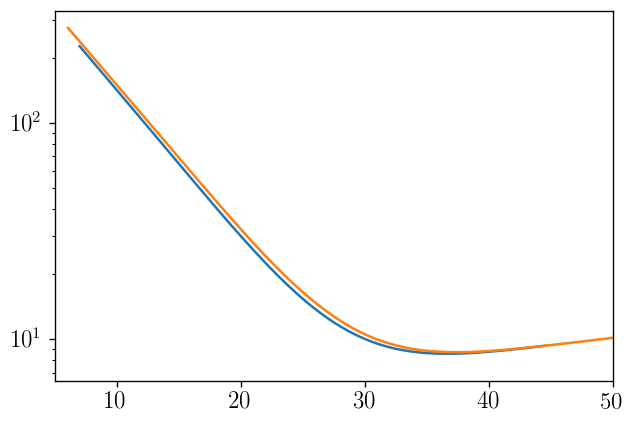

In [57]:
fig, ax = plt.subplots()
ax.plot(1+rfine['z'], rfine['E_phot'])
ax.plot(soln['rs'], [s.toteng() for s in soln['highengphot']])
ax.set(xlim=(5, 50))
ax.set(yscale='log')

[None]

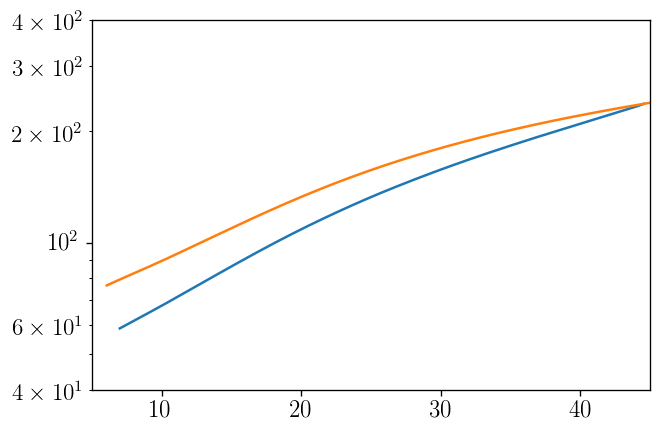

In [58]:
fig, ax = plt.subplots()
ax.plot(1+rfine['z'], rfine['T_k'])
ax.plot(soln['rs'], soln['Tm']/phys.kB)
ax.set(xlim=(5, 45), ylim=(40, 400))
ax.set(yscale='log')

[None]

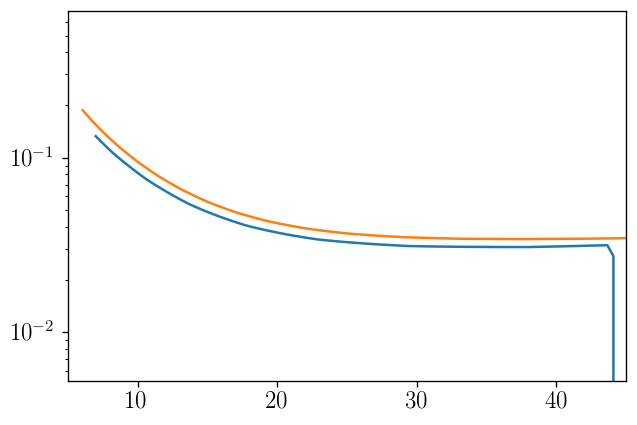

In [26]:
fig, ax = plt.subplots()
ax.plot(1+rfine['z'], rfine['f_heat'])
ax.plot(soln['rs'], soln['f']['low']['heat']+soln['f']['high']['heat'])
ax.set(xlim=(5, 45))
ax.set(yscale='log')

In [31]:
dh_f_heat = interpolate.interp1d(soln['rs'], soln['f']['low']['heat']+soln['f']['high']['heat'])(1+rfine['z'])

In [35]:
(rfine['f_heat'] / dh_f_heat)[0]

0.0

In [41]:
from dm21cm.evolve import get_z_edges

In [43]:
z_edges = get_z_edges(44, 6, 1.01)

In [44]:
z_edges[:5]

array([43.99817883, 43.55265231, 43.11153694, 42.67478905, 42.2423654 ])

In [45]:
rfine['z'][0]

43.55265231097704

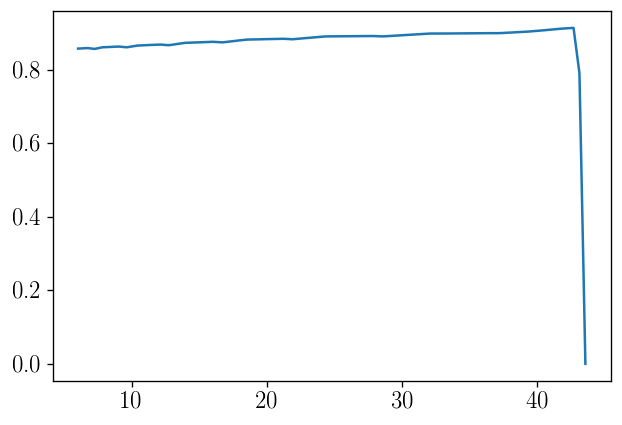

In [34]:
plt.plot(rfine['z'], rfine['f_heat'] / dh_f_heat)

In [ ]:
s = np.load("../data/run_info/phph_dhinit_s8zero_slices.npy", allow_pickle=True)